## SRJ

In [ ]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity






def ags_exact(symbols, coordinates, active_electrons, active_orbitals, adapt_it, shots = None):
    print('Using active space, check if you change the H accordingly')
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method="pyscf",active_electrons=active_electrons, active_orbitals=active_orbitals)
    core, active = qml.qchem.active_space(electrons, orbitals, active_electrons=active_electrons, active_orbitals=active_orbitals) # Spatial orbitals
    print('core orbitals:', core)
    print('active orbitals:', active)
    print(H)
    hf_state = qchem.hf_state(active_electrons, qubits)
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, active_electrons, qubits, H):
        #print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    

    
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, active_electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(active_electrons, qubits)
    print('Singles are', singles)
    print('Doubles are', doubles)
    print('In adapt, singles are', len(singles))
    print('In adapt, doubles are', len(doubles))
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    print('Total excitations are', len(operator_pool))
    states = [hf_state]
    params = np.zeros(len(ash_excitation), requires_grad=True) 

    null_state = np.zeros(qubits,int)
    print('Null state is', null_state)

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            #print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        #print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value


        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation

        params = np.append(params, 0.0)  #Parameters initialization



        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = 1e-12, options = {'disp': False, 'maxiter': 1e8})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)


        ostate = new_state(hf_state, ash_excitation, params)
        #print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        gs_state = ostate
        states.append(ostate)
        
    return gs_state, params, ash_excitation, qubits, H

## So if you want the state, return the ostate and not states


import os
from time import time
import pennylane as qml
from pennylane import numpy as np
import scipy
configd = []

#elec: 8, spin-orb: 12
def inite(elec,orb):
    config=[]
    list1=[]
    #singles
    for x in range(elec):
        count=elec
        while (count<orb):
            for e in range(elec):
                if x==e:
                    if x%2==0:
                        config.append(count)
                        count = count+2
                    else:
                        config.append(count+1)
                        count=count+2
                else:
                    config.append(e)
                    
            #print('Config singles', config)
            #print('Len of singles in excited states', len(config))    
            list1.append(config)
            config=[]
    print('Len of singles', len(list1))
    #doubles
    for x in range(elec):
        for y in range(x+1,elec):
            print('I am changing orb-elec')
            count1=orb-elec
            count2=orb-elec
            print('Doubles, count1', count1)
            print('Doubles, count2', count2)
            for count1 in range(elec, orb, 2):
                for count2 in range(elec, orb, 2):
                    cont=0
                    if count1==count2:
                        if (x%2)!=(y%2):
                            cont=1
                    else:
                        cont=1
                    if (x%2)==(y%2) and count2<count1:
                        cont=0
                    if cont==1:    
                        for e in range(elec):
                            if x==e:
                                if x%2==0:
                                    config.append(count1)
                                else:
                                    config.append(count1+1)
                            elif y==e:
                                if y%2==0:
                                    config.append(count2)
                                else:
                                    config.append(count2+1)
                            else:
                                config.append(e)
                        #print('Config', config)
                        list1.append(config)
                        print('lenght of total exc:', len(list1))
                        config=[]
    return list1

def ee_exact(symbols, coordinates, active_electrons, active_orbitals ,params,ash_excitation, shots=0):
    print('The no of active electrons:', active_electrons)
    print('The no of active orbitals:', active_orbitals)
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-3g", method="pyscf", active_electrons=active_electrons, active_orbitals=active_orbitals)
    hf_state = qml.qchem.hf_state(active_electrons, qubits)
    print('HF state:', hf_state)
    singles, doubles = qml.qchem.excitations(active_electrons, qubits)
    wires=range(qubits)
    

    null_state = np.zeros(qubits,int)
    print('Null state is', null_state)
    list1 = inite(active_electrons,qubits)
    print('The list1 :', list1)
    print('Len of list1', len(list1))
    values =[]
    for t in range(1):
        if shots==0:
            dev = qml.device("lightning.qubit", wires=qubits)
        else:

            dev = qml.device("lightning.qubit", wires=qubits,shots=shots)
        #circuit for diagonal part
        @qml.qnode(dev)
        def circuit_d(params, occ,wires, hf_state, ash_excitation):
            #print('What is going  as hf_State:', hf_state)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ:
                qml.X(wires=w)
            #Going to include excitations here
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
                elif len(ash_excitation[i]) == 2:
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #circuit for off-diagonal part
        @qml.qnode(dev)
        def circuit_od(params, occ1, occ2,wires, hf_state, ash_excitation):
            #print('What is going  as hf_State:', hf_state)
            #print('The occ1', occ1)
            #print('The occ2', occ2)
            qml.BasisState(hf_state, wires=range(qubits))
            for w in occ1:
                qml.X(wires=w)
            first=-1
            for v in occ2:
                if v not in occ1:
                    if first==-1:
                        first=v
                        #print('Hadamard applied to',v)
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for v in occ1:
                if v not in occ2:
                    #print('Checking if its printing anything')
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for i, excitations in enumerate(ash_excitation):
                if len(ash_excitation[i]) == 4:
                    qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
                elif len(ash_excitation[i]) == 2:
                    qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
            return qml.expval(H)
        #final M matrix
        M = np.zeros((len(list1),len(list1)))
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i == j:
                    M[i,i] = circuit_d(params, list1[i], wires, null_state, ash_excitation)
        print("diagonal parts done")
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i!=j:
                    Mtmp = circuit_od(params, list1[i],list1[j],wires, null_state, ash_excitation)
                    M[i,j]=Mtmp-M[i,i]/2.0-M[j,j]/2.0
        print("off diagonal terms done")
        #ERROR:not subtracting the gs energy
        eig,evec=np.linalg.eig(M)
        values.append(np.sort(eig))
    return values

symbols  = [ 'F', 'F']
print('F2-1.413A-GS+ES-DBS')
r_bohr = 1.8897259886 
coordinates = np.array([[0.0,0.0, 0.0*r_bohr], [0.0, 0.0, 1.413*r_bohr]])

print(coordinates)

electrons = 18 # 7 from N and 3 from H
orbitals = 20 #Spin - Prince said its spin  
charge = 0

active_electrons = 14
active_orbitals = 8 #Spatial orbitals


gs_state, params, ash_excitation, qubits, H = ags_exact(symbols, coordinates, active_electrons, active_orbitals, shots = None, adapt_it=1) #1 is used for params



print('The params after GS is',params)
print('Ash excitation after gs state:', ash_excitation)



eig = ee_exact(symbols, coordinates,active_electrons,active_orbitals,params,ash_excitation)
print('exact eigenvalues:\n', eig)


F2-1.413A-GS+ES-DBS
[[0.         0.         0.        ]
 [0.         0.         2.67018282]]
Using active space, check if you change the H accordingly
core orbitals: [0, 1]
active orbitals: [2, 3, 4, 5, 6, 7, 8, 9]
-180.73024517911782 * I([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) + 2.3938935758665543 * Z(0) + -0.10227863652628333 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Y(8)) + -0.10227863652628333 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ X(8)) + 2.2256474869980662 * Z(2) + 0.09683726850320033 * (Z(0) @ Z(2)) + -0.11354867363131589 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Z(12) @ Z(13) @ Y(14)) + -0.11354867363131589 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Z(12) @ Z(13) @ X(14)) + -0.004800503931135528 * (Z(0) @ Y(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Z(11) @ Z(12) @ Z(13) @ Y(14)) + -0.004800503931135528 * (Z(0) @ X(2) @ Z(3) @ Z(4) @ Z(5) @ Z(

/Users/s.poyyapakkam/miniconda3/envs/an/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Highest gradient excitation is [8, 9, 14, 15]
Current parameters: [0.50871205]
Current cost: -196.03909012087806

Current parameters: [0.50871205]
Current cost: -196.0390901208781

Final updated parameters: [0.50871205]
Final cost: -196.0390901208781
The adapt iteration now is 1
Highest gradient excitation is [0, 9, 14, 15]
Current parameters: [0.50871201 0.07435867]
Current cost: -196.04158250423092

Current parameters: [0.51193961 0.07446932]
Current cost: -196.04158547760318

Current parameters: [0.51194482 0.07446951]
Current cost: -196.0415854776134

Final updated parameters: [0.51194482 0.07446951]
Final cost: -196.0415854776134
The adapt iteration now is 2
Highest gradient excitation is [0, 1, 14, 15]
Current parameters: [0.51194482 0.07446951 0.04882292]
Current cost: -196.04318051708105

Current parameters: [0.50643479 0.07439005 0.04905918]
Current cost: -196.0431892089179

Current parameters: [0.50640624 0.07438964 0.04906041]
Current cost: -196.04318920915318

Final updated

In [2]:
energy14 = np.array([-196.049558878985, -195.88755719, -195.88755719, -195.85077278, -195.85077278,
        -195.77956173, -195.77956173, -195.77899737, -195.76658714,
        -195.76658714, -195.69212032, -195.68313308, -195.68313308,
        -195.67780544, -195.65620197, -195.65417924, -195.65417924,
        -195.6524503 , -195.27154879, -195.21908046, -195.21908046,
        -195.1688749 , -195.13186231, -195.12687663, -195.12687663,
        -195.1253338 , -195.1253338 , -195.07644576, -195.06122681,
        -195.06122681, -195.05157448, -195.05157448, -195.03058918,
        -195.03058918, -195.00860578, -194.97579714, -194.93445707,
        -194.7581976 , -194.73370809, -194.72083715, -194.72083715,
        -194.68945209, -194.65599663, -194.65599663, -194.64056815,
        -194.64056815, -194.63399244, -194.63399244, -194.38382518,
        -194.30643105, -194.30643105, -194.23964702, -194.23964702,
        -194.17975748, -193.99644716, -193.97640967, -193.92110455,
        -193.92110455, -193.88212978, -193.88212978, -193.65587861,
        -193.59486879, -193.08938528, -193.01196244])

In [3]:
fenergy14 = np.array([-196.0495958 , -195.88756413, -195.88756413, -195.85077504,
       -195.85077504, -195.77956641, -195.77956641, -195.7790113 ,
       -195.76659258, -195.76659258, -195.69212045, -195.68313322,
       -195.68313322, -195.67781951, -195.65620212, -195.6541794 ,
       -195.6541794 , -195.65245081, -195.2716664 , -195.21911619,
       -195.21911619, -195.16887503, -195.13186246, -195.12691082,
       -195.12691082, -195.12537436, -195.12537436, -195.07650288,
       -195.06122693, -195.06122693, -195.05161067, -195.05161067,
       -195.03058933, -195.03058933, -195.0088339 , -194.97585304,
       -194.93477499, -194.75826859, -194.73384414, -194.72088335,
       -194.72088335, -194.68957182, -194.65605513, -194.65605513,
       -194.64065049, -194.64065049, -194.63406227, -194.63406227,
       -194.38389726, -194.30643887, -194.30643887, -194.23966124,
       -194.23966124, -194.17980361, -193.99661786, -193.9766363 ,
       -193.921295  , -193.921295  , -193.88230647, -193.88230647,
       -193.6560094 , -193.59505208, -193.08963274])

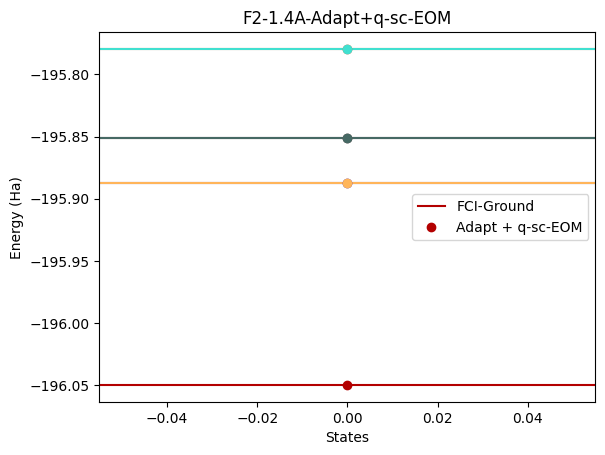

In [4]:
import matplotlib.pyplot as plt





plt.axhline(y=fenergy14[0], color="#b30000", linestyle='-', label='FCI-Ground')
plt.axhline(y=fenergy14[1], color="#4421af", linestyle='-')
plt.axhline(y=fenergy14[2], color="#ffb55a", linestyle='-')
plt.axhline(y=fenergy14[3], color="#6d4b4b", linestyle='-')
plt.axhline(y=fenergy14[4], color="#466964", linestyle='-')
plt.axhline(y=fenergy14[5], color="#FF5733", linestyle='-')
plt.axhline(y=fenergy14[6], color="#40E0D0", linestyle='-')

plt.plot(0, energy14[0],'o', color = '#b30000', label = 'Adapt + q-sc-EOM') 
plt.plot(0, energy14[1], 'o', color = '#4421af')
plt.plot(0, energy14[2], 'o', color = '#ffb55a')
plt.plot(0, energy14[3], 'o', color = '#6d4b4b')
plt.plot(0, energy14[4], 'o', color = '#466964')
plt.plot(0, energy14[5], 'o', color = '#FF5733')
plt.plot(0, energy14[6], 'o', color = '#40E0D0')


#plt.plot(1, ccsd_35_35n[5], 'v', color = '#40E0D0')

plt.legend()
#plt.ylim(-55.20, -55.10)
plt.xlabel('States')
plt.ylabel('Energy (Ha)')
plt.title('F2-1.4A-Adapt+q-sc-EOM')

plt.show()